<a href="https://colab.research.google.com/github/Akechi1412/Phishing-Website-Detection/blob/main/model_training/trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Train Phishing Website Detection Model**

## **Connect to Drive and Github responsitory**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Github
%cd Phishing-Website-Detection/model_training
!git config --global user.email "nguyenphong10042002@gmail.com"
!git config --global user.name "Akechi1412"
!git fetch origin
!git reset --hard origin/main

/content/drive/MyDrive/Github
/content/drive/MyDrive/Github/Phishing-Website-Detection/model_training
HEAD is now at 2f5af1b Merge branch 'main' of https://github.com/Akechi1412/Phishing-Website-Detection


## **Load data**

In [3]:
!pip install aiohttp

In [4]:
from utils import load_data

In [5]:
data_size=50000
data_train, data_val, data_test = load_data(data_size=data_size)

In [6]:
print(len(data_train), len(data_val), len(data_test))
print(data_train[0])

80000 10000 10000
{'url': 'https://adminserver356.weebly.com/', 'html': '<!DOCTYPE html>\n<html lang="en">\n\t<head>\n\t\t<title>server admin</title><meta property="og:site_name" content="" />\n<meta property="og:title" content="My Site" />\n<meta property="og:description" content="" />\n<meta property="og:image" content="https://cdn2.editmysite.com/images/site/footer/og-image-placeholder-blank.png" />\n<meta property="og:url" content="https://adminserver356.weebly.com/" />\n\n\n\n<meta http-equiv="Content-Type" content="text/html; charset=utf-8"/>\n\t<meta name="viewport" content="width=device-width, initial-scale=1.0">\n\n\t\t\n\t\t<link id="wsite-base-style" rel="stylesheet" type="text/css" href="//cdn2.editmysite.com/css/sites.css?buildTime=1709139612" />\n<link rel="stylesheet" type="text/css" href="//cdn2.editmysite.com/css/old/fancybox.css?1709139612" />\n<link rel="stylesheet" type="text/css" href="//cdn2.editmysite.com/css/social-icons.css?buildtime=1709139612" media="screen,p

In [7]:
# Extracting train data
url_train = [item['url'] for item in data_train]
html_train = [item['html'] for item in data_train]
label_train = [item['label'] for item in data_train]

# Extracting validation data
url_val = [item['url'] for item in data_val]
html_val = [item['html'] for item in data_val]
label_val = [item['label'] for item in data_val]

# Extracting test data
url_test = [item['url'] for item in data_test]
html_test = [item['html'] for item in data_test]
label_test = [item['label'] for item in data_test]

## **Create word-based URL representation**

In [8]:
from utils import split_url, build_dictionary, transform_url
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Text(0, 0.5, 'Frequency (Number of URLs)')

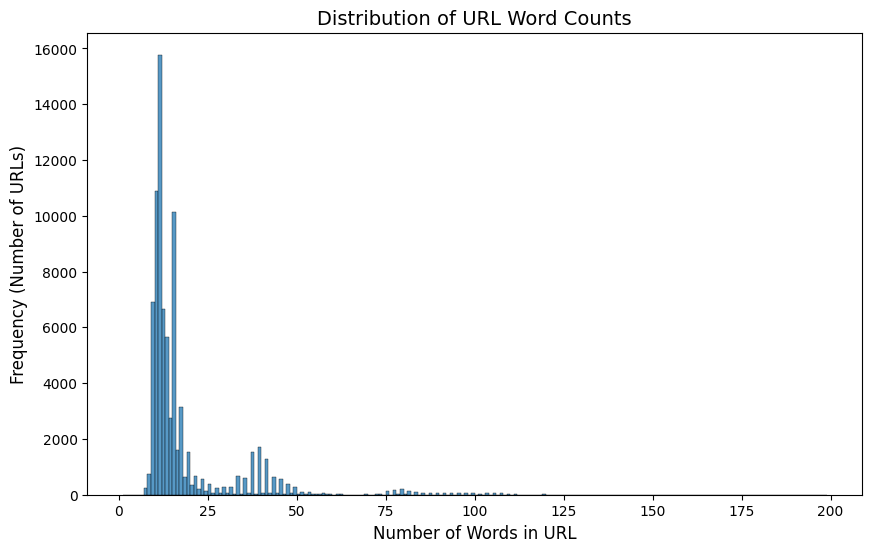

In [9]:
word_counts = [len(split_url(url)) for url in url_train]
plt.figure(figsize=(10, 6))
sns.histplot(word_counts, bins=range(1, 200), kde=False)
plt.title('Distribution of URL Word Counts', fontsize=14)
plt.xlabel('Number of Words in URL', fontsize=12)
plt.ylabel('Frequency (Number of URLs)', fontsize=12)


In [10]:
word_size = 50
vocab_size = 10000

filename = 'models/dictionary.pkl'
words = []
for url in url_train:
    words.extend(split_url(url))
dictionary = build_dictionary(words, vocab_size=vocab_size, filename=filename)

url_train = np.array([transform_url(url, dictionary, word_size=word_size) for url in url_train])
url_val = np.array([transform_url(url, dictionary, word_size=word_size) for url in url_val])
url_test = np.array([transform_url(url, dictionary, word_size=word_size) for url in url_test])

Dictionary saved to models/dictionary.pkl


In [11]:
print(url_train[0])

[   4    3    1    1 9825    2   38    2    7    1    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


## **Create graph-based HTML DOM representation**

In [12]:
!pip install lxml

In [13]:
from utils import parse_html, create_graph, create_graph_adjacency, create_graph_feature
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import multiprocessing

In [14]:
def count_nodes(html):
    dom_tree = parse_html(html)
    graph = create_graph(dom_tree)
    return len(graph.nodes())

def statistic_nodes(htmls, max_workers=4):
    node_counts = []
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        node_counts = list(executor.map(count_nodes, html_train))
    return node_counts

/content/drive/MyDrive/Github/Phishing-Website-Detection/model_training/utils.py:173: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  dom_tree = BeautifulSoup(html_document, 'lxml')
/content/drive/MyDrive/Github/Phishing-Website-Detection/model_training/utils.py:173: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  dom_tree = BeautifulSoup(html_document, 'lxml')
/content/drive/MyDrive/Github/Phishing-Website-Detection/model_training/utils.py:173: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  dom_tree = BeautifulSoup(html_document, 'lxml')
/content/drive/MyDrive/Github/Phishing-Website-Detection/model_training/uti

Text(0, 0.5, 'Frequency (Number of HTMLs)')

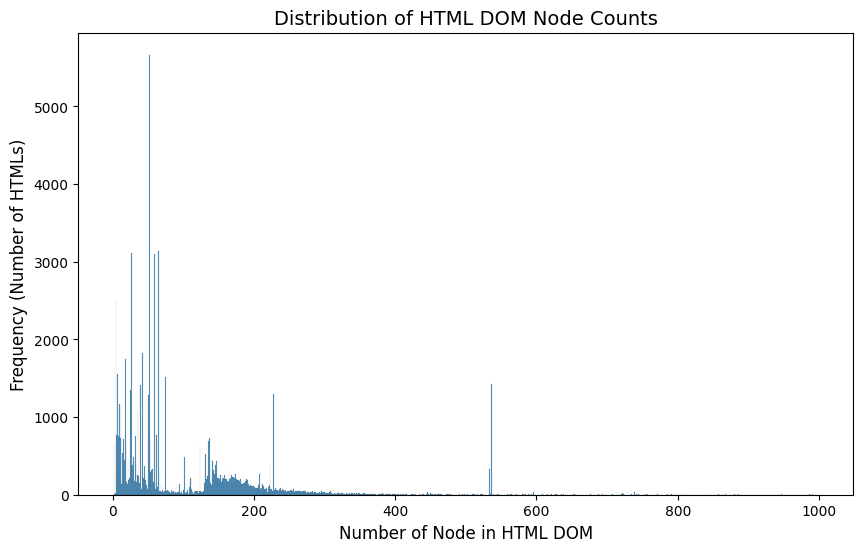

In [15]:
node_counts = statistic_nodes(html_train, max_workers=8)
plt.figure(figsize=(10, 6))
sns.histplot(node_counts, bins=range(1, 1000), kde=False)
plt.title('Distribution of HTML DOM Node Counts', fontsize=14)
plt.xlabel('Number of Node in HTML DOM', fontsize=12)
plt.ylabel('Frequency (Number of HTMLs)', fontsize=12)

In [16]:
def process_html(html):
    dom_tree = parse_html(html)
    return create_graph(dom_tree)

def process_html_documents(htmls, max_workers=4):
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        graphs = list(executor.map(process_html, htmls))
    return graphs

In [17]:
node_size = 300

graph_train = process_html_documents(html_train, max_workers=8)
graph_val = process_html_documents(html_val, max_workers=8)
graph_test = process_html_documents(html_test, max_workers=8)

ga_train = np.array([create_graph_adjacency(graph, node_size=node_size) for graph in graph_train])
ga_val = np.array([create_graph_adjacency(graph, node_size=node_size) for graph in graph_val])
ga_test = np.array([create_graph_adjacency(graph, node_size=node_size) for graph in graph_test])

gf_train = np.array([create_graph_feature(graph, node_size=node_size) for graph in graph_train])
gf_val = np.array([create_graph_feature(graph, node_size=node_size) for graph in graph_val])
gf_test = np.array([create_graph_feature(graph, node_size=node_size) for graph in graph_test])

/content/drive/MyDrive/Github/Phishing-Website-Detection/model_training/utils.py:173: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  dom_tree = BeautifulSoup(html_document, 'lxml')
/content/drive/MyDrive/Github/Phishing-Website-Detection/model_training/utils.py:173: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  dom_tree = BeautifulSoup(html_document, 'lxml')
/content/drive/MyDrive/Github/Phishing-Website-Detection/model_training/utils.py:173: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  dom_tree = BeautifulSoup(html_document, 'lxml')
/content/drive/MyDrive/Github/Phishing-Website-Detection/model_training/uti

In [31]:
print(ga_train[0], gf_train[0])

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0.         0.         0.        ]
 [0.01666667 0.         0.        ]
 [0.03333333 0.         0.        ]
 [0.06666667 0.         0.        ]
 [0.05       0.         0.        ]
 [0.78333333 0.         0.        ]
 [0.78333333 0.         0.        ]
 [0.78333333 0.         0.        ]
 [0.78333333 0.         0.        ]
 [0.78333333 0.         0.        ]
 [0.78333333 0.         0.        ]
 [0.78333333 0.         0.        ]
 [0.76666667 1.         0.        ]
 [0.76666667 1.         0.        ]
 [0.76666667 1.         0.        ]
 [0.76666667 1.         0.        ]
 [0.76666667 1.         0.        ]
 [0.76666667 1.         0.        ]
 [0.8        0.         0.        ]
 [0.8        0.         0.        ]
 [0.75       0.         1.        ]
 [0.75       0.         0.        ]
 [0.75       0.         1.        ]
 [0.75       0. 

In [18]:
print(ga_train.shape, gf_train.shape)

(80000, 300, 300) (80000, 300, 3)


## **Create models functions**

### **Create URL model using Transformer Neutral Network**

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

In [20]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

class PositionalEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [21]:
def create_url_model(vocab_size, word_size, embed_dim,
                     num_heads, ff_dim, num_transformer_layers):
    inputs = keras.Input(shape=(word_size,), dtype=tf.int32)
    x = PositionalEmbedding(word_size, vocab_size, embed_dim)(inputs)

    for _ in range(num_transformer_layers):
        x = TransformerEncoder(embed_dim, num_heads, ff_dim)(x)

    x = layers.GlobalAveragePooling1D()(x)
    url_model = keras.Model(inputs=inputs, outputs=x)
    return url_model

### **Create HTML model using Graph Convolution Network**

In [22]:
!pip install spektral

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 2.9 MB/s eta 0:00:00


In [23]:
from spektral.layers import GCNConv, GlobalSumPool

In [24]:
def create_html_model(node_size, feature_dim, gcn_units):
    inputs_adj = keras.Input(shape=(node_size, node_size), dtype=tf.float32)
    inputs_feat = keras.Input(shape=(node_size, feature_dim), dtype=tf.float32)

    gcn_layer = GCNConv(gcn_units, activation='relu')([inputs_feat, inputs_adj])
    pooled_output = GlobalSumPool()(gcn_layer)

    html_model = keras.Model(inputs=[inputs_adj, inputs_feat], outputs=pooled_output)
    return html_model

### **Create full model**

In [27]:
def create_full_model(vocab_size, word_size, embed_dim, num_heads, ff_dim, num_transformer_layers, node_size, feature_dim, gcn_units, mha_units):
    # URL Model
    url_model = create_url_model(vocab_size, word_size, embed_dim, num_heads, ff_dim, num_transformer_layers)

    # HTML Model
    html_model = create_html_model(node_size, feature_dim, gcn_units)

    # Inputs
    url_inputs = keras.Input(shape=(word_size,), dtype=tf.int32)
    adj_inputs = keras.Input(shape=(node_size, node_size), dtype=tf.float32)
    feat_inputs = keras.Input(shape=(node_size, feature_dim), dtype=tf.float32)

    # Outputs from both models
    url_output = url_model(url_inputs)  # (None, embed_dim)
    html_output = html_model([adj_inputs, feat_inputs])  # (None, gcn_units)

    # Concatenate the outputs (both are 2D now)
    combined = layers.Concatenate()([url_output, html_output])  # (None, embed_dim + gcn_units)

    # MHA Model
    mha_output = layers.Dense(mha_units)(combined)  # (None, mha_units)

    # Final layers
    x = layers.Dense(128, activation='relu')(mha_output)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    full_model = keras.Model(inputs=[url_inputs, adj_inputs, feat_inputs], outputs=outputs)
    return full_model

## **Train model**

In [28]:
label_train = np.array(label_train)
label_val = np.array(label_val)
label_test = np.array(label_test)

model = create_full_model(vocab_size=vocab_size,
                          word_size=word_size,
                          embed_dim=64,
                          num_heads=4,
                          ff_dim=128,
                          num_transformer_layers=2,
                          node_size=node_size,
                          feature_dim=3,
                          gcn_units=64,
                          mha_units=64)

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_filepath = 'models/best_model.keras'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

history = model.fit([url_train, ga_train, gf_train], label_train,
          validation_data=([url_val, ga_val, gf_val], label_val),
          epochs=10, batch_size=128,
          callbacks=[checkpoint_callback])

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_11 (InputLayer)       [(None, 300, 300)]           0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 300, 3)]             0         []                            
                                                                                                  
 model_3 (Functional)        (None, 64)                   809600    ['input_10[0][0]']            
                                                                                            

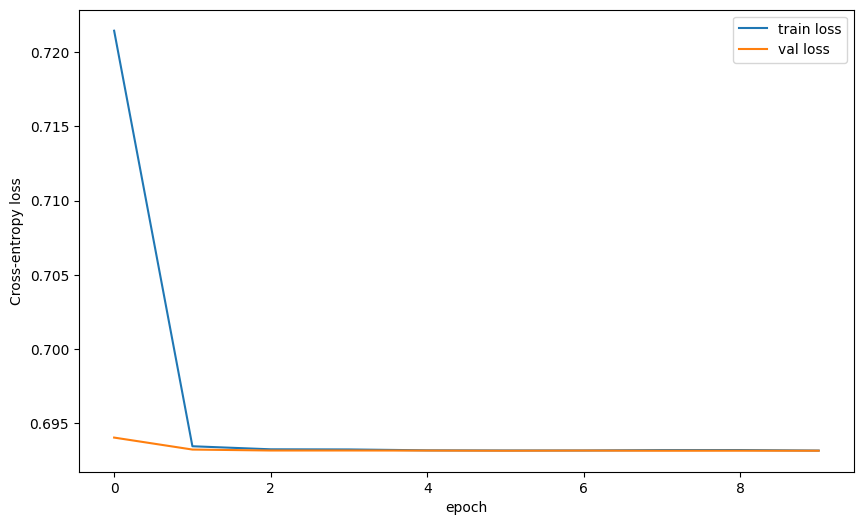

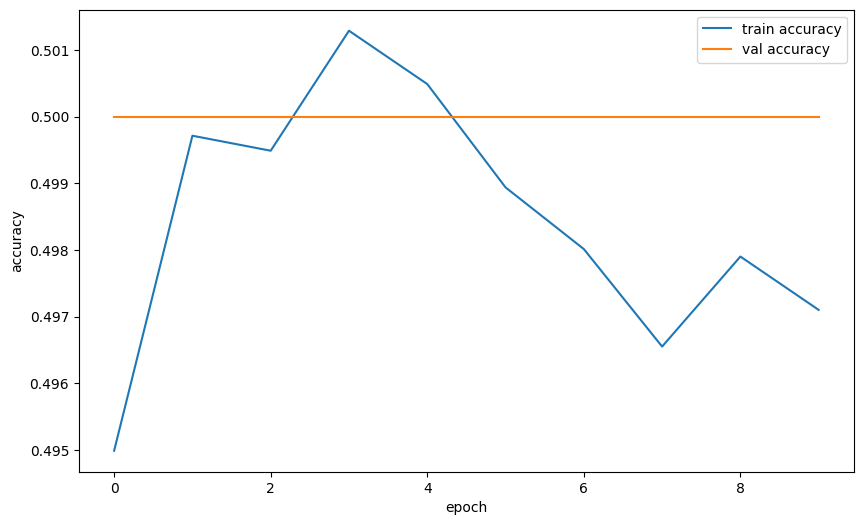

In [29]:
# Plot history loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend()
plt.show()

# Plot history accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()